<a href="https://colab.research.google.com/github/daemon-Lee/simplex_method_for_linear_program/blob/master/project/simplex_method/Simplex_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2020 Duy L.Dinh. { display-mode: "form" }
#@markdown CS1302 HE130655.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Project MAO302
This is final project of MAO302 Course make by FPT University

## Part 1: simplex method for linear program (LP)

In [ ]:
import numpy as np
np.random.seed(2020)

### Generate input matrices of a standard linear program in matrix from

In [ ]:
def gen_problem(n_var, n_contrain):
    
    contrain = np.random.randint(low=-7, high=19, size=(n_var,n_contrain))
    bacis = np.eye(n_contrain)

    # A will contain the coefficients of the constraints 
    A = np.vstack((contrain,bacis)).T

    # b will contain the amount of resources 
    b = np.random.randint(low=-7, high=19, size=(n_contrain,))


    # c will contain coefficients of objective function Z
    cz = np.random.randint(low=-7, high=19, size=(n_var,))
    cb = np.zeros((n_contrain,))
    c = np.concatenate([cz,cb])
    
    return A, b, c

### Write a code to solve the generated LP using to phase simplex method in matrix form


In [ ]:
#@title THE SIMPLEX METHOD IN MATRIX NOTATION
class Simplex_method:
#@markdown First input A, b, c, where:
#@markdown - **A** will contain the coefficients of the constraints
#@markdown - **b** will contain the amount of resources
#@markdown - **c** will contain coefficients of objective function Z
    def __init__(self, A, b, c):
        self.A = A
        self.c = c
        self.B = 0
        self.n = 0
#@markdown Generate *B* and *N*
#@markdown - **B** will contain the Basic set
#@markdown - **n** will contain the nonbasic set
        n_contrain = len(self.A)
        n_var = len(self.c) - n_contrain

        self.B = np.arange(n_var, n_var + n_contrain)[np.newaxis].T
        self.n = np.arange(0, n_var)[np.newaxis].T

#@markdown - The initial values of the basic variables: xb = b
        self.xb = np.transpose([b])
#@markdown - The initial values of the nonbasic dual variables: zn = -cn
        self.zn = -self.c[self.n]
        
        self.status = 'Optimal'
        self.objective = 0

    def solve(self, verbor=False):
        self.count = 0
        for i in self.n:
            if True not in (self.A[:, i] > 0) and self.c[i] > 0:
                print("Unbounded")
                self.status = 'Unbounded'
                
                sol = np.zeros(len(self.c))
                sol[self.B] = self.xb

                return {
                    'status': self.status,
                    "iter": self.count,
                    "objective": self.objective,
                    "sol": sol
                }

#@markdown Find solution for problem

#@markdown - Check for Optimality. If xb ≥ 0 and zn ≥ 0, stop. The current 
#@markdown solution is optimal.
        if False not in (self.xb >= 0) and False not in (self.zn <= 0):
            print("Optimal — the problem was trivial")
            sol = np.zeros(len(self.c))
            sol[self.B] = self.xb

            return {
                'status': self.status,
                "iter": self.count,
                "objective": self.objective,
                "sol": sol
            }

#@markdown - Since xb ≥ 0, the initial solution is **Primal feasible**, and hence  
#@markdown we can apply the simplex method without needing any Phase I procedure.
        elif False not in (self.xb >= 0) and False in (self.zn <= 0):
            print("primal feasible")
            print("run primal simplex method")
            result = self.primal_simplex(verbor=verbor)

#@markdown - Since xb ≥ 0, the initial solution is **Dual feasible**
        elif False in (self.xb >= 0) and False not in (self.zn <= 0):
            print("run dual simplex method")
            result = self.solve_two_phase(verbor=verbor)

#@markdown - Where both xb and cn have components of the wrong sign.
#@markdown In this case, we must employ a **two-phase procedure**.
        else:
            print("dual feasible")
            print("Start convert negative components")
            # self.zn = np.maximum(self.zn, -self.zn)
            # self.zn = np.maximum(self.zn, 0)

            print("run two phase simplex method")
            result = self.solve_two_phase(verbor=verbor)

        return result

    def solve_two_phase(self, verbor=False):
#@markdown - In Phase I apply the dual simplex method to find an optimal solution 
#@markdown of this modified problem Phase I is most likely not optimal, but it 
#@markdown is feasible, and therefore the primal simplex method can be used to 
#@markdown find the optimal solution to the original problem.
        print("Phase one")
        result = self.dual_simplex(verbor=verbor)

        if result['status'] == 'Infeasible':
            return result

        print("Phase two")
        result = self.primal_simplex(verbor=verbor)

        return result

    def primal_simplex(self, verbor=False):
        objective = -np.inf
        count = 0
        Bi = self.A[:, self.B].reshape((-1, len(self.B)))
        N = self.A[:, self.n].reshape((-1, len(self.n)))

        if verbor:
            A_hat = np.concatenate([self.B.T, self.xb.T, N.T, Bi.T]).T
            print("Objective\n", np.concatenate([self.zn, self.xb]).T)
            print("Dictionary\n", A_hat)

        while(np.min(self.zn) < 0):

            j = np.argmin(self.zn)
            ej = np.zeros((1, len(self.zn))).T
            ej[j] = 1

            delta_xb = np.linalg.inv(Bi).dot(N).dot(ej)

            t = np.max(delta_xb/self.xb)**-1

            if t < 0 or t == np.inf:
                self.status = 'Unbounded'
                sol = np.zeros(len(self.c))
                sol[self.B] = self.xb
                return {
                    'status': self.status,
                    "iter": self.count,
                    "objective": self.objective,
                    "sol": sol
                }

            i = np.argmax(delta_xb/self.xb)
            ei = np.zeros((1, len(self.xb))).T
            ei[i] = 1

            delta_zn = -(np.linalg.inv(Bi).dot(N)).T.dot(ei)
            s = self.zn[j]/delta_zn[j]

            self.xb = self.xb - t*delta_xb
            self.zn = self.zn - s*delta_zn

            self.xb[i] = t
            self.zn[j] = s

            # pivot swap
            pivot = self.B[i].copy()
            self.B[i] = self.n[j].copy()
            self.n[j] = pivot

            Bi = self.A[:, self.B].reshape((-1, len(self.B)))
            N = self.A[:, self.n].reshape((-1, len(self.n)))

            count += 1
            self.count += 1
            self.objective = self.xb.T.dot(self.c[self.B]).reshape(-1)[0]

            if verbor:
                A_hat = np.concatenate([self.B.T, self.xb.T, N.T, Bi.T]).T
                print("iter:", count)
                print("Dictionary\n", A_hat)
                print("objective:", self.objective)

            if self.objective > objective:
                objective = self.objective
            else:
                self.status = 'Infeasible'
                sol = np.zeros(len(self.c))
                sol[self.B] = self.xb
                return {
                    'status': self.status,
                    "iter": self.count,
                    "objective": self.objective,
                    "sol": sol
                }

        sol = np.zeros(len(self.c))
        sol[self.B] = self.xb

        return {
            'status': self.status,
            "iter": self.count,
            "optimal": self.objective,
            "sol": sol
        }

    def dual_simplex(self, verbor=False):

        objective = np.inf
        count = 0
        Bi = self.A[:, self.B].reshape((-1, len(self.B)))
        N = self.A[:, self.n].reshape((-1, len(self.n)))

        if verbor:
            A_hat = np.concatenate([self.B.T, self.xb.T, N.T, Bi.T]).T
            print("Objective\n", np.concatenate([self.zn, self.xb]).T)
            print("Dictionary\n", A_hat)

        while(np.min(self.xb) < 0):
            i = np.argmin(self.xb)
            ei = np.zeros((1, len(self.xb))).T
            ei[i] = 1

            delta_zn = -(np.linalg.inv(Bi).dot(N)).T.dot(ei)

            s = np.max(delta_zn/self.zn)**-1

            j = np.argmax(delta_zn/self.zn)
            ej = np.zeros((1, len(self.zn))).T
            ej[j] = 1

            delta_xb = np.linalg.inv(Bi).dot(N).dot(ej)

            t = self.xb[i]/delta_xb[i]

            self.xb = self.xb - t*delta_xb
            self.zn = self.zn - s*delta_zn

            self.xb[i] = t
            self.zn[j] = s

            # pivot
            pivot = self.B[i].copy()
            self.B[i] = self.n[j].copy()
            self.n[j] = pivot

            Bi = self.A[:, self.B].reshape((-1, len(self.B)))
            N = self.A[:, self.n].reshape((-1, len(self.n)))

            A_hat = np.concatenate([self.B.T, self.xb.T, N.T, Bi.T]).T

            count += 1
            self.count += 1
            self.objective = self.xb.T.dot(self.c[self.B]).reshape(-1)[0]

            if verbor:
                A_hat = np.concatenate([self.B.T, self.xb.T, N.T, Bi.T]).T
                print("iter:", count)
                print("Dictionary\n", A_hat)
                print("objective:", self.objective)

            if self.objective < objective:
                objective = self.objective
            else:
                self.status = 'Infeasible'
                sol = np.zeros(len(self.c))
                sol[self.B] = self.xb
                return {
                    'status': self.status,
                    "iter": self.count,
                    "objective": self.objective,
                    "sol": sol
                }

        sol = np.zeros(len(self.c))
        sol[self.B] = self.xb

        return {
            'status': self.status,
            "iter": self.count,
            "objective": self.objective,
            "sol": sol
        }

In [ ]:
print("Exercise 2.3")
# A will contain the coefficients of the constraints
A = np.array([[-1, -1, -1, 1, 0],
              [2, -1,  1, 0, 1]])

# b will contain the amount of resources
b = np.array([-2, 1])

# c will contain coefficients of objective function Z
c = np.array([2, -6, 0, 0, 0])

Exercise 2.3


In [ ]:
simplex = Simplex_method(A, b, c)

print(simplex.solve(verbor=True))

dual feasible
Start convert negative components
run two phase simplex method
Phase one
Objective
 [[-2  6  0 -2  1]]
Dictionary
 [[ 3 -2 -1 -1 -1  1  0]
 [ 4  1  2 -1  1  0  1]]
iter: 1
Dictionary
 [[ 2.  2. -1. -1.  1. -1.  0.]
 [ 4. -1.  2. -1.  0.  1.  1.]]
objective: 0.0
iter: 2
Dictionary
 [[ 2.  3.  0. -1.  1. -1. -1.]
 [ 0. -1.  1. -1.  0.  1.  2.]]
objective: -2.0
iter: 3
Dictionary
 [[ 2.   1.5  0.  -1.   1.  -1.  -1. ]
 [ 1.   0.5  1.   2.   0.   1.  -1. ]]
objective: -3.0
Phase two
Objective
 [[3.  1.  3.  1.5 0.5]]
Dictionary
 [[ 2.   1.5  0.  -1.   1.  -1.  -1. ]
 [ 1.   0.5  1.   2.   0.   1.  -1. ]]
{'status': 'Optimal', 'iter': 3, 'optimal': -3.0, 'sol': array([0. , 0.5, 1.5, 0. , 0. ])}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:210: RuntimeWarning: divide by zero encountered in true_divide


### Solve the genarated LP by a pulp and cplex tool

#### pulp lib

Install pulp

In [ ]:
!pip install pulp

In [ ]:
print("Exercise 2.3")
# A will contain the coefficients of the constraints
A = np.array([[-1, -1, -1, 1, 0],
              [2, -1,  1, 0, 1]])

# b will contain the amount of resources
b = np.array([-2, 1])

# c will contain coefficients of objective function Z
c = np.array([2, -6, 0, 0, 0])

Exercise 2.3


In [ ]:
import pulp as p

# Generate B and N
n_contrain = len(A)
n_var = len(c) - n_contrain

B = np.arange(n_var, n_var + n_contrain)[np.newaxis].T
n = np.arange(0, n_var)[np.newaxis].T

# Create a LP Minimization problem 
Lp_prob = p.LpProblem('Problem', p.LpMaximize) 

# Create problem Variables
x = [p.LpVariable("x"+str(i), lowBound = 0) for i in range(1,n_var+1)]

# Objective Function 
objective = 0
for i in range(n_var):
    objective += c[i]*x[i]

Lp_prob += objective 

# Constraints:
for i in range(n_contrain):
    contrain = 0
    for j in range(n_var):
        contrain += A[i,j]*x[j] <= b[i]/n_var
    Lp_prob += contrain

# Display the problem 
print(Lp_prob) 

status = Lp_prob.solve() # Solver 
print(p.LpStatus[status]) # The solution status 

# Printing the final solution 
print(p.value(x[0]), p.value(x[1]), p.value(x[2]), p.value(Lp_prob.objective))

Problem:
MAXIMIZE
2*x1 + -6*x2 + 0
SUBJECT TO
_C1: - x1 - x2 - x3 <= -2

_C2: 2 x1 - x2 + x3 <= 1

VARIABLES
x1 Continuous
x2 Continuous
x3 Continuous

Optimal
0.0 0.5 1.5 -3.0


In [ ]:
import pulp as p
def pulp_lib(A, b, c, verbor=False):
    # Generate B and N
    n_contrain = len(A)
    n_var = len(c) - n_contrain

    B = np.arange(n_var, n_var + n_contrain)[np.newaxis].T
    n = np.arange(0, n_var)[np.newaxis].T

    # Create a LP Minimization problem 
    Lp_prob = p.LpProblem('Problem', p.LpMaximize) 

    # Create problem Variables
    x = [p.LpVariable("x"+str(i), lowBound = 0) for i in range(1,n_var+1)]

    # Objective Function 
    objective = 0
    for i in range(n_var):
        objective += c[i]*x[i]

    Lp_prob += objective 

    # Constraints:
    for i in range(n_contrain):
        contrain = 0
        for j in range(n_var):
            contrain += A[i,j]*x[j] <= b[i]/n_var
        Lp_prob += contrain

    status = Lp_prob.solve() # Solver 
    
    if verbor:
        print(p.LpStatus[status]) # The solution status 
        # Printing the final solution 
        print(p.value(Lp_prob.objective))
    
    return {
        'status': p.LpStatus[status],
        'objective': p.value(Lp_prob.objective)
    }

#### cplex

In [ ]:
!pip install cplex

In [ ]:
import cplex
def cplex_lib(A, b, c):
    # Input all the data and parameters here
    num_constraints = len(A)
    num_decision_var = len(c) - num_constraints
    
    n = np.arange(0, num_decision_var)[np.newaxis].T

    A = A[:,n.T].reshape(num_constraints, num_decision_var).tolist()
    b = b.tolist()
    c = c[n].T.reshape(len(n)).tolist()

    # constraint_type = ["L", "L", "L"] # Less, Greater, Equal
    constraint_type = ["L"]*num_constraints
    # ============================================================

    # Establish the Linear Programming Model
    myProblem = cplex.Cplex()

    # Add the decision variables and set their lower bound and upper bound (if necessary)
    myProblem.variables.add(names= ["x"+str(i) for i in range(num_decision_var)])
    for i in range(num_decision_var):
        myProblem.variables.set_lower_bounds(i, 0.0)

    # Add constraints
    for i in range(num_constraints):
        myProblem.linear_constraints.add(
            lin_expr= [cplex.SparsePair(ind= [j for j in range(num_decision_var)], val= A[i])],
            rhs= [b[i]],
            names = ["c"+str(i)],
            senses = [constraint_type[i]]
        )

    # Add objective function and set its sense
    for i in range(num_decision_var):
        myProblem.objective.set_linear([(i, c[i])])
    myProblem.objective.set_sense(myProblem.objective.sense.maximize)

    # Solve the model and print the answer
    myProblem.solve()
    return{
        'objective': myProblem.solution.get_objective_value(),
        'status': myProblem.solution.get_status_string(),
        'sol': myProblem.solution.get_values()
    }

In [ ]:
print("Exercise 2.3")
# A will contain the coefficients of the constraints
A = np.array([[-1, -1, -1, 1, 0],
              [2, -1,  1, 0, 1]])

# b will contain the amount of resources
b = np.array([-2, 1])

# c will contain coefficients of objective function Z
c = np.array([2, -6, 0, 0, 0])

Exercise 2.3


In [ ]:
cplex_lib(A, b, c)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =             0.000000
Iteration:     2   Dual objective     =            -2.000000


{'objective': -3.0, 'sol': [0.0, 0.5, 1.5], 'status': 'optimal'}

### Repeat (1)-(3) one hundred timnes and compare the mean and standard deviation of running time of your code with those of the chosen tool.

In [ ]:
n_sample = 100

In [ ]:
np.random.seed(2020)
A_list = []
b_list = []
c_list = []
for i in range(n_sample):
    n_var = np.random.randint(low=2, high=7)
    n_contrain = np.random.randint(low=2, high=7)
    A, b, c = gen_problem(n_var, n_contrain)
    A_list.append(A)
    b_list.append(b)
    c_list.append(c)

In [ ]:
from time import time

In [ ]:
running_time_pulp = []
output_pulp = []
for i in range(n_sample):
    start = time()
    output_pulp.append(pulp_lib(A, b, c, verbor=False))
    end = time() - start
    running_time_pulp.append(end)

In [ ]:
running_time_cplex = []
output_cplex = []
for i in range(n_sample):
    start = time()
    output_cplex.append(pulp_lib(A, b, c, verbor=False))
    end = time() - start
    running_time_cplex.append(end)

In [ ]:
running_time_simplex_method = []
output_simplex_method= []
for i in range(n_sample):
    start = time()
    simplex = Simplex_method(A, b, c)
    output_simplex_method.append(simplex.solve(verbor=False))
    end = time() - start
    running_time_simplex_method.append(end)

run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simplex method
Phase one
run dual simpl

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:208: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:210: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
#@title Compare pulp and Simplex method

# Simplex method
mean_Simplex_method = np.mean(running_time_simplex_method)
std_Simplex_method = np.std(running_time_simplex_method)

# pulp
mean_pulp = np.mean(running_time_pulp)
std_pulp = np.std(running_time_pulp)

# cplex
mean_cplex = np.mean(running_time_cplex)
std_cplex = np.std(running_time_cplex)

print("mean running time of pulp - simplex_method (s):", mean_pulp - mean_Simplex_method)
print("standard deviation running time of pulp - simplex_method (s):", std_pulp - std_Simplex_method)

mean running time of pulp - simplex_method (s): 0.008444607257843018
standard deviation running time of pulp - simplex_method (s): 0.00010279611569166919


In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

[Text(0.5, 0, 'code'), Text(1.5, 0, 'pulp'), Text(2.5, 0, 'cplex')]

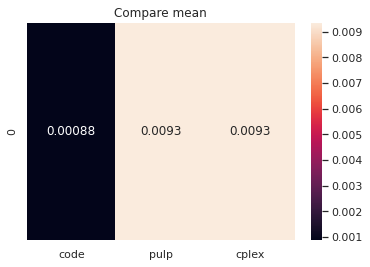

In [ ]:
mean = np.array([mean_Simplex_method, mean_pulp, mean_cplex])[np.newaxis]
ax = sns.heatmap(mean, annot=True)
plt.title("Compare mean")
ax.set_xticklabels(['code','pulp','cplex'])

[Text(0.5, 0, 'code'), Text(1.5, 0, 'pulp'), Text(2.5, 0, 'cplex')]

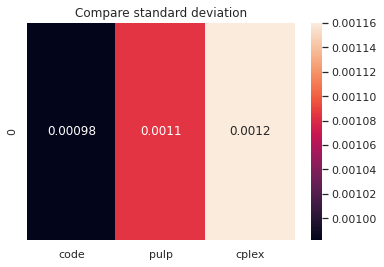

In [ ]:
std = np.array([std_Simplex_method, std_pulp, std_cplex])[np.newaxis]
ax = sns.heatmap(std, annot=True)
plt.title("Compare standard deviation")
ax.set_xticklabels(['code','pulp','cplex'])